# MLD Analysis of Seeded Colloid simulations HCP in a Wedge

In [1]:
import numpy as np
import scipy.io
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import fsolve
from scipy.optimize import leastsq
from scipy.signal import find_peaks
from scipy.integrate import solve_ivp
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import scipy as sp
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["computer modern roman"],
    "font.size": 20})

plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

def mscatter(x,y,ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

# Surface Volume

In [2]:
SurfVol = 1045801

In [3]:
AllSimsCol = pd.read_excel(r'./cgmods/AllSimsColloids.xlsx')
AllSimsCol['Vol'] = AllSimsCol['Lx'] * AllSimsCol['Ly'] * AllSimsCol['Lz']
#AllSimsCol.drop(index=22, inplace=True)
#AllSimsCol.reset_index(drop=True, inplace=True)

In [4]:
ratio = AllSimsCol['Nss'] / AllSimsCol['xtal']
seed_xtl_ratio = AllSimsCol['hcp'] / AllSimsCol['xtal']

# Define thresholds
ratiocutoff = 0.5  # hcp/fcc xtal fraction cutoff
amorphous_cutoff = 5  # Nss/xtal threshold for amorphous aggregates

# Marker
AllSimsCol['m'] = np.select(
    [
        np.isinf(ratio),                 # no crystal
        ratio > amorphous_cutoff,        # amorphous
        seed_xtl_ratio <= ratiocutoff,    # defect-rich
        seed_xtl_ratio > ratiocutoff      # good crystal
    ],
    [
        'x',   # no crystal
        'o',   # amorphous
        '^',   # fcc-rich
        '^'    # good crystal
    ]
)

# Color
AllSimsCol['c'] = np.select(
    [
        np.isinf(ratio),                 # no crystal
        ratio > amorphous_cutoff,        # amorphous
        seed_xtl_ratio <= ratiocutoff,    # defect-rich
        seed_xtl_ratio > ratiocutoff      # good crystal
    ],
    [
        'black',   # no crystal
        'green',   # amorphous
        'blue',    # hcp-rich
        'red'      # good (CNT) crystal
    ]
)


## Load data
dataCol = AllSimsCol[(AllSimsCol['m'] == '^') & (AllSimsCol['c'] == 'red')].reset_index(drop=True)

print('SYTSTEMS WITH NO STABLE CRYSTAL: \n')
print(AllSimsCol[~((AllSimsCol['m'] == '^') & (AllSimsCol['c'] == 'red'))])


SYTSTEMS WITH NO STABLE CRYSTAL: 

                       label         Lx        Ly         Lz  Ntot   density  \
2   RSEED5.0_ZSCALE1.0_RHO97  156.49532  154.8902  158.07951   805  0.002402   
3   RSEED5.0_ZSCALE1.2_RHO97  156.49532  154.8902  189.69541   805  0.002002   
25  RSEED7.0_ZSCALE1.2_RHO95  156.49532  154.8902  189.69541  1560  0.002166   

        Nss    Nss err    xtal  xtal err     fcc    fccerr     hcp    hcperr  \
2     73.98  24.310895    0.20  0.400000    0.02  0.140000    0.17  0.375633   
3     28.10   8.307226    0.08  0.305941    0.01  0.099499    0.07  0.291719   
25  1270.40   8.446301  715.45  8.861574  367.03  5.010898  347.65  8.125731   

        fdil           Vol  m      c  
2   0.908099  3.831783e+06  o  green  
3   0.965093  4.598139e+06  o  green  
25  0.185641  4.598139e+06  ^   blue  


In [5]:
## Constants
## Avogadro
NA=6.02214076E23
## kT
kT=1 #LJ units (T=2)

## Total Volume
VCol=dataCol.Lx*dataCol.Ly*dataCol.Lz - SurfVol
p0Col=kT*(dataCol.Ntot)/VCol

## Densities
weightCol=10
densfcc=0.008135305 # bulk fcc crystal (sigma^-3) 
## Colloid volume
vlCol=np.power(densfcc,-1) # sigma^3

## Output data table
print(dataCol)

                        label         Lx        Ly         Lz  Ntot   density  \
0    RSEED5.0_ZSCALE1.0_RHO93  156.49532  154.8902  158.07951  1616  0.002614   
1    RSEED5.0_ZSCALE1.0_RHO95  156.49532  154.8902  158.07951  1198  0.002505   
2   RSEED6.0_ZSCALE0.65_RHO91  156.49532  154.8902  102.75168  1040  0.003790   
3   RSEED6.0_ZSCALE0.65_RHO92  156.49532  154.8902  102.75168   961  0.003758   
4   RSEED6.0_ZSCALE0.72_RHO91  156.49532  154.8902  113.81725  1040  0.003422   
5   RSEED6.0_ZSCALE0.72_RHO92  156.49532  154.8902  113.81725   961  0.003393   
6   RSEED6.0_ZSCALE0.75_RHO91  156.49532  154.8902  118.55963  1040  0.003285   
7   RSEED6.0_ZSCALE0.75_RHO92  156.49532  154.8902  118.55963   961  0.003257   
8   RSEED6.0_ZSCALE0.78_RHO92  156.49532  154.8902  123.30202  1355  0.003264   
9   RSEED6.0_ZSCALE0.78_RHO93  156.49532  154.8902  123.30202  1228  0.003221   
10   RSEED6.0_ZSCALE0.7_RHO92  156.49532  154.8902  110.65566   961  0.003490   
11   RSEED6.0_ZSCALE0.7_RHO9

In [6]:
## Reaction Coordinate
dataRC = dataCol.Nss
print(dataRC)

0     1397.27
1      923.33
2      869.08
3      795.78
4      829.86
5      769.06
6      821.72
7      763.61
8     1171.96
9     1007.25
10     749.26
11     817.80
12    1345.65
13    1152.67
14    1310.98
15    1140.19
16    1298.30
17    1159.89
18    1548.48
19    1088.78
20     646.24
21    1473.00
22    1717.92
23     793.97
Name: Nss, dtype: float64


# Set the Solubility

In [7]:
## Define Function -> Equilibrium Condition
#ERR=lambda tpl, p0, p1, vl, rss, kT, : p1-tpl[0]*np.exp(2*(tpl[1])*vl/(rss*kT)) #  
ERR=lambda tpl, p0, p1, vl, rss, kT, peq, : p1-peq*np.exp(2*(tpl[0])*vl/(rss*kT)) #  
#Initial Guess

## Fitting BootStrap
NsimulationsCol=np.shape(dataCol.label)[0]
REPS=2000
#peqCol=np.zeros(REPS)
peqCol = 2.31829e-05#2.35702e-05
sigmaCol=np.zeros(REPS)

In [8]:
##  Bootstrap estimate of the fitted parameters Col
for REP in np.arange(0,REPS):
    #choose Nsimulations random simulations (with repetition)
    simulations=np.random.randint(0,NsimulationsCol,NsimulationsCol)
    guess=np.random.rand(2);
    p1=kT*(dataCol.Ntot[simulations]-dataRC[simulations])/(VCol[simulations]-dataRC[simulations]*vlCol)
    p0=kT*(dataCol.Ntot[simulations])/VCol[simulations]
    rss=np.power(3*dataRC[simulations]*vlCol/4/np.pi,1/3)
    
    ## Least squares fitting
    #tplFitted => tuple of fitted parameters
    tplFitted,success=leastsq(ERR,guess,args=(p0, p1, vlCol,rss,kT,peqCol),full_output=0,maxfev=1000,ftol=1E-15,gtol=1E-15)

    #peqCol[REP]=tplFitted[0]
    sigmaCol[REP]=tplFitted[0]

The equilibrium density of the dilute phase is: 2.31829e-05 +/- 0.0
The surface tension is: 0.188883541831069 +/- 0.004992665915191279


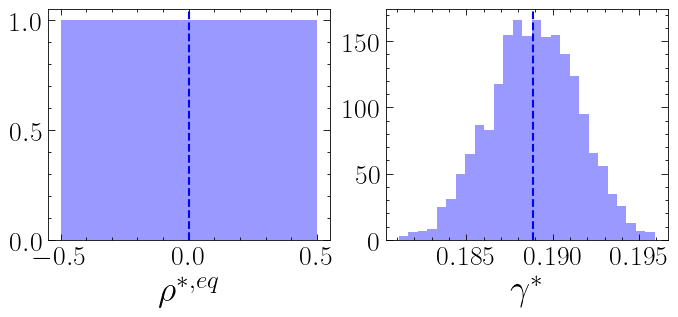

In [9]:
## Equilibrium vapour pressure
peq_Col_estimate=np.mean(peqCol)

## Equilibrium density of the dilute phase 
LD_Col=peqCol/kT
LD_Col_estimate=np.mean(LD_Col)
LD_Col_err=1.96*np.std(LD_Col) # 95% confidence interval
    
fig,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].hist(LD_Col, bins = 'auto',alpha=0.4,color='blue')
ax[0].set_xlabel('$\\rho^{*,eq}$',fontsize=26)
ax[0].axvline(x=LD_Col_estimate, color='blue', linestyle='--', linewidth=1.5, label="x=2")
#plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
#plt.savefig('panel_2_parameters', dpi=600, bbox_inches='tight');
print('The equilibrium density of the dilute phase is:',LD_Col_estimate,'+/-',LD_Col_err)


## Surface tension
sigma_Col_estimate=np.mean(sigmaCol)
sigma_Col_err=1.96*np.std(sigmaCol) # 95% confidence interval
    
ax[1].hist(sigmaCol, bins = 'auto',alpha=0.4,color='blue')
ax[1].set_xlabel('$\\gamma^{*}$',fontsize=26)
#plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
ax[1].axvline(x=sigma_Col_estimate, color='blue', linestyle='--', linewidth=1.5, label="x=2")
plt.savefig('Fitted_params_Kelvin.png', dpi=600, bbox_inches='tight');

print('The surface tension is:',sigma_Col_estimate,'+/-',sigma_Col_err)

In [10]:
## Define Function -> Equilibrium Condition
#ERR=lambda tpl, p0, p1, vl, rss, kT, : p1-tpl[0]*np.exp(2*(tpl[1])*vl/(rss*kT)) #  
#ERR = lambda tpl, n, p1, vl, kT: -np.log(p1/tpl[0]) - vl*(p1 - tpl[0]) + 2/(3*kT)*tpl[1]*n**(-1/3)
#ERR = lambda tpl, n, p1, vl, kT: -np.log(p1/np.exp(tpl[0])) - vl*(p1 - np.exp(tpl[0])) + 2/(3*kT)*tpl[1]*n**(-1/3)
ERR = lambda tpl, n, p1, vl, kT, peq: -np.log(p1/peq) - vl*(p1 - peq) + 2/(3*kT)*tpl[0]*n**(-1/3)

## Fitting BootStrap
NsimulationsCol=np.shape(dataCol.label)[0]
REPS=2000
#pequilCol=np.zeros(REPS)
pequilCol=peqCol
sigmaprimeCol=np.zeros(REPS)

In [11]:
##  Bootstrap estimate of the fitted parameters Col
for REP in np.arange(0,REPS):
    #choose Nsimulations random simulations (with repetition)
    simulations=np.random.randint(0,NsimulationsCol,NsimulationsCol)
    guess=np.random.rand(2);
    #guess = [np.log(np.median(p1)), 1.0]
    n = dataCol.Nss[simulations]
    p1=kT*(dataCol.Ntot[simulations]-dataRC[simulations])/(VCol[simulations]-dataRC[simulations]*vlCol)
    
    ## Least squares fitting
    #tplFitted => tuple of fitted parameters
    tplFitted,success=leastsq(ERR,guess,args=(n, p1, vlCol, kT, pequilCol),full_output=0,maxfev=1000,ftol=1E-15,gtol=1E-15)

    #pequilCol[REP] = np.exp(tplFitted[0])
    sigmaprimeCol[REP] = tplFitted[0]

The equilibrium density of the dilute phase is: 2.31829e-05 +/- 0.0
Sigma prime is: 22.57845051506463 +/- 0.5663292358295001


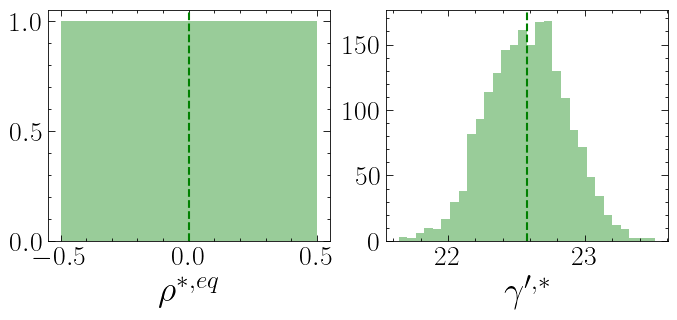

In [12]:
## Equilibrium vapour pressure
pequil_Col_estimate=np.mean(pequilCol)

## Equilibrium density of the dilute phase 
VD_Col=pequilCol/kT
VD_Col_estimate=np.mean(VD_Col)
VD_Col_err=1.96*np.std(VD_Col) # 95% confidence interval
    
fig,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].hist(VD_Col, bins = 'auto',alpha=0.4,color='green')
ax[0].set_xlabel('$\\rho^{*,eq}$',fontsize=26)
ax[0].axvline(x=VD_Col_estimate, color='green', linestyle='--', linewidth=1.5, label="x=2")
#plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
#plt.savefig('panel_2_parameters', dpi=600, bbox_inches='tight');
print('The equilibrium density of the dilute phase is:',VD_Col_estimate,'+/-',VD_Col_err)


## Surface tension
sigmaprime_Col_estimate=np.mean(sigmaprimeCol)
sigmaprime_Col_err=1.96*np.std(sigmaprimeCol) # 95% confidence interval
    
ax[1].hist(sigmaprimeCol, bins = 'auto',alpha=0.4,color='green')
ax[1].set_xlabel('$\\gamma^{\prime,*}$',fontsize=26)
#plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
ax[1].axvline(x=sigmaprime_Col_estimate, color='green', linestyle='--', linewidth=1.5, label="x=2")
plt.savefig('Fitted_params.png', dpi=600, bbox_inches='tight');

print('Sigma prime is:',sigmaprime_Col_estimate,'+/-',sigmaprime_Col_err)

# Estimate the shape factor from sigma prime

In [13]:
alCol = (36*np.pi*vlCol**2)**(1/3) # Colloid area
shape = sigmaprime_Col_estimate/(sigma_Col_estimate*alCol)
print('Shape factor is estimated to be:',shape)

Shape factor is estimated to be: 0.9998429420888866


# Plot Figure 2

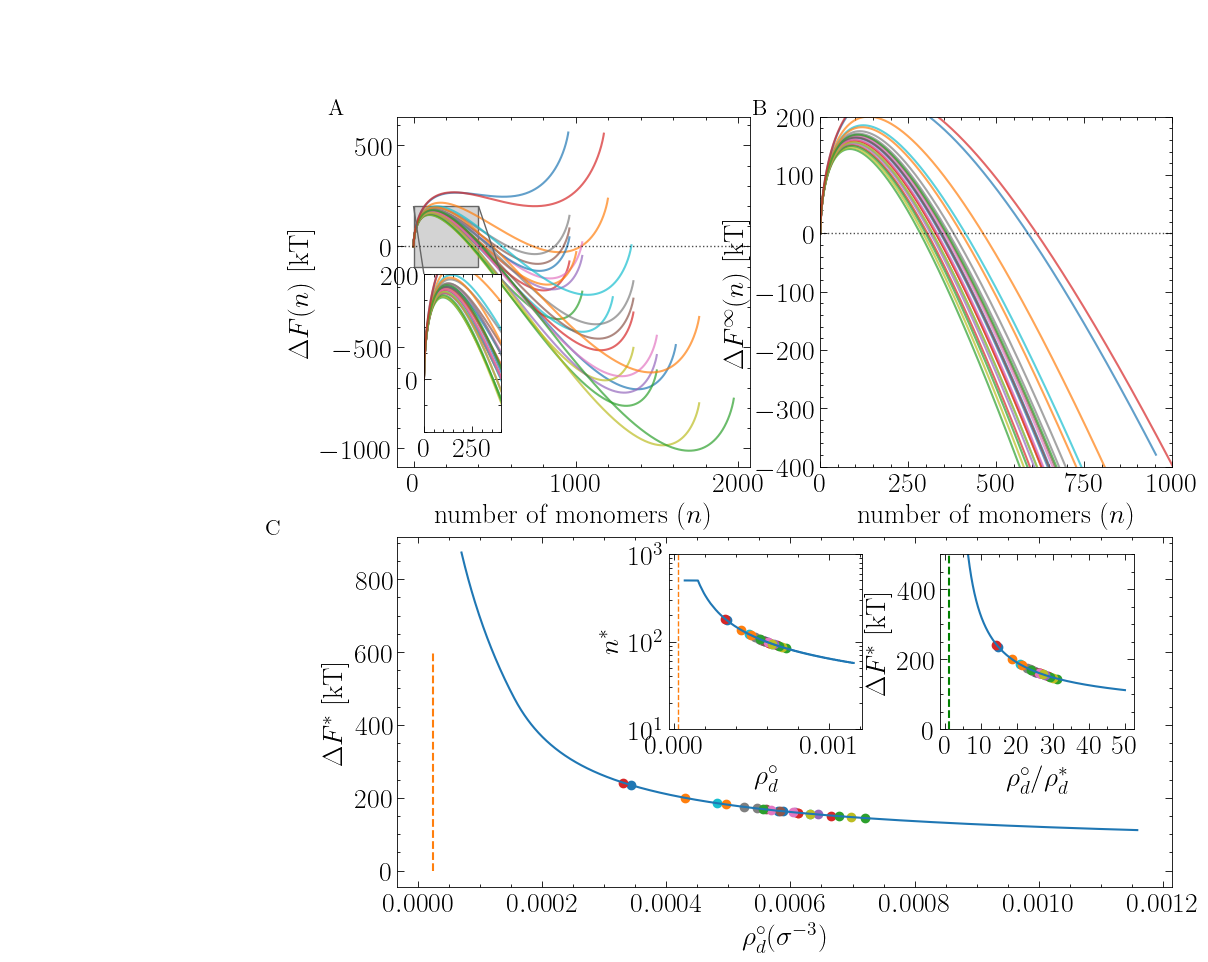

In [14]:
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

#from matplotlib.ticker import AutoMinorLocator
## Define FES confined and macroscopic
#FES_confined=lambda nn, N, peq, sigma, p0, p1, vl, r, kT, : -nn*kT*np.log(p1/peq)+sigma*4*np.pi*np.power(r,2)+nn*(kT-vl*peq)+N*kT*np.log(p1/p0);
FES_confined=lambda nn, N, peq, sigma, p0, p1, vl, r, kT, : -nn*kT*np.log(p1/peq)+sigma*np.power(nn,2/3)+nn*(kT-vl*peq)+N*kT*np.log(p1/p0);

#FES_macro=lambda nn, peq, sigma, p0, r, kT, : -nn*kT*np.log(p0/peq)+sigma*4*np.pi*np.power(r,2);
FES_macro=lambda nn, peq, sigma, p0, r, kT, : -nn*kT*np.log(p0/peq)+sigma*np.power(nn,2/3);

## Plot sub-figures setup
#fig = plt.figure(figsize=(10, 10))
#sub0 = fig.add_subplot(2,2,1)
#sub1 = fig.add_subplot(2,2,2)
#sub2 = fig.add_subplot(2,2,(3,4))

fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(2, 2, figure=fig)

sub0 = fig.add_subplot(gs[0, 0])   # top-left
sub1 = fig.add_subplot(gs[0, 1])   # top-right
sub2 = fig.add_subplot(gs[1, :])   # bottom row spanning both columns

#fig.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    #wspace=0.4,
                    #hspace=0.4)

## labels
sub1.set_xlabel('number of monomers ($n$)')
sub1.set_ylabel('$\Delta F^{\infty}(n)$ [kT]')
sub2.set_xlabel('$\\rho_d^\circ (\sigma^{-3})$')
sub2.set_ylabel('$\\Delta{F}^*$ [kT]')
sub0.set_xlabel('number of monomers ($n$)')
sub0.set_ylabel('$\Delta F(n)$ [kT]')

## insets
ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(sub0, [0.075,0.1,0.22,0.45])
ax2.set_axes_locator(ip)
ax2.set_xlim([0,400])
ax2.set_ylim([-100,200]) 
mark_inset(sub0, ax2, loc1=1, loc2=2, fc="lightgray", ec='0.4')

## insets
ax3 = plt.axes([1,1,1,1])
ip2 = InsetPosition(sub2, [0.35,0.45,0.25,0.5])
ax3.set_axes_locator(ip2)
ax3.set_xlabel('$\\rho_d^\circ$')
ax3.set_ylabel('$n^*$')

ax4 = plt.axes([1,1,1,1])
ip2 = InsetPosition(sub2, [0.7,0.45,0.25,0.5])
ax4.set_axes_locator(ip2)
ax4.set_xlabel('$\\rho_d^\circ/\\rho_d^*$')
ax4.set_ylabel('$\\Delta{F}^*$ [kT]')

## label 
#sub0.text(-0.1, 1.10, 'A', transform=sub0.transAxes,verticalalignment='center')
#sub1.text(-0.2, 1.10, 'B', transform=sub1.transAxes,verticalalignment='center')
#sub2.text(-0.2, 1.10, 'C', transform=sub2.transAxes,verticalalignment='center')
for ax, label in zip([sub0, sub1, sub2], ['A', 'B', 'C']):
    ax.text(-0.15, 1.05, label, transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='right')


## Compute FUS Free Energies (and plot panel 1)

argminF_Col=np.zeros(NsimulationsCol)
argmaxF_Col=np.zeros(NsimulationsCol)

for SIM in np.arange(0,NsimulationsCol):
    ## Compute FES given the fitted parameters
    nn=np.linspace(0, dataCol.Ntot[SIM]-1, num=1000)
    p0=p0Col[SIM]
    p1=kT*(dataCol.Ntot[SIM]-nn)/(VCol[SIM]-nn*vlCol)
    r=np.power(3*nn*vlCol/4/np.pi,1/3);
    #FES=FES_confined(nn,dataCol.Ntot[SIM],peq_Col_estimate,sigma_Col_estimate,p0,p1,vlCol,r,kT)   
    #FESm=FES_macro(nn, peq_Col_estimate, sigma_Col_estimate, p0, r, kT)
    FES=FES_confined(nn,dataCol.Ntot[SIM],pequil_Col_estimate,sigmaprime_Col_estimate,p0,p1,vlCol,r,kT)   
    FESm=FES_macro(nn, pequil_Col_estimate, sigmaprime_Col_estimate, p0, r, kT)
    
    lineCol,=sub0.plot(nn,FES,alpha=0.7)
    ax2.plot(nn,FES,alpha=0.7,ls="-")

    lineColm1,=sub1.plot(nn,FESm,alpha=0.7,ls='-')
    
    #sub1.set_ylim([-20,24])
    #sub1.set_xlim([0,34])
    sub1.set_ylim([-400,200])
    sub1.set_xlim([0,1000])
    
    ## Compute steady state droplet size, critical nucleus size, and nucleation barrier
    argminF_Col[SIM]=nn[FES==np.min(FES)]
    argmaxF_Col[SIM]=nn[FESm==np.max(FESm)]
    #DF_Col[SIM]=np.max(FESm)
    ## Plot stuff in subpanels
    sub2.scatter(p0/kT,np.max(FESm))
    ax3.scatter(p0/kT,argmaxF_Col[SIM])
    #ax4.scatter(p0/kT/LD_Col_estimate,np.max(FESm))
    ax4.scatter(p0/kT/VD_Col_estimate,np.max(FESm))
    
sub0.axhline(0,color="black",alpha=0.7,lw=1.0,ls=":")
sub1.axhline(0,color="black",alpha=0.7,lw=1.0,ls=":")
    
## Compute nucleation barrier and critical nucleus size as a fulineDDXm,nction of system size from the model
nn=np.linspace(0, 500, num=1000)
#P0=np.linspace(peq_Col_estimate*3,peq_Col_estimate*50,1000)
P0=np.linspace(pequil_Col_estimate*3,pequil_Col_estimate*50,1000)
DFCol=np.zeros(np.shape(P0))
ncritCol=np.zeros(np.shape(P0))
for i in np.arange(0,np.shape(P0)[0]):
    p0=P0[i]
    r=np.power(3*nn*vlCol/4/np.pi,1/3);
    #FESm=FES_macro(nn, peq_Col_estimate, sigma_Col_estimate, p0, r, kT)
    FESm=FES_macro(nn, pequil_Col_estimate, sigmaprime_Col_estimate, p0, r, kT)
    DFCol[i]=np.max(FESm)
    ncritCol[i]=nn[FESm==np.max(FESm)]
sub2.plot(P0/kT,DFCol)
ax3.plot(P0/kT,ncritCol)
#ax4.plot(P0/kT/LD_Col_estimate,DFCol)
ax4.plot(P0/kT/VD_Col_estimate,DFCol)

## Plot critical nucleus sizes in inset
#ax3.plot([LD_Col_estimate, LD_Col_estimate],[10, 1000],'--',linewidth=1.0)
ax3.plot([VD_Col_estimate, VD_Col_estimate],[10, 1000],'--',linewidth=1.0)
ax3.set_yscale("log")
ax3.set_ylim([10,1000])


# Plot equilibrium density estimate with confidence interval
#sub2.plot([LD_Col_estimate, LD_Col_estimate],[0, 600],'--')
sub2.plot([VD_Col_estimate, VD_Col_estimate],[0, 600],'--')

# Plot sencond inset scale
ax4.set_ylim(0,500)
ax4.set_xticks([0, 10, 20, 30, 40, 50])
ax4.xaxis.set_minor_locator(AutoMinorLocator(2))
ax4.plot([1,1],[0, 600],'--',color="green")

nlines=7
ncols=3
sub0.legend(frameon=False,fontsize=16,ncol=2,handletextpad=0.1,loc="upper right")
lgd=sub2.legend(loc=(-0.5, 2.45),frameon=False,ncol=2,fontsize=18)


plt.savefig('FEcurves.png', dpi=100, bbox_inches='tight');

plt.show()

In [15]:
from scipy.signal import find_peaks

#P0=np.linspace(0.4*peq_Col_estimate,peq_Col_estimate*200,1000)
P0=np.linspace(0.4*pequil_Col_estimate,pequil_Col_estimate*200,1000)
Vtot=np.power(np.linspace(20,250,1000),3)
[PP0,VVtot]=np.meshgrid(P0,Vtot)
NNtot=VVtot*PP0/kT

               
CLASS_Col=np.zeros(np.shape(NNtot))
CLASS_P1=np.zeros(np.shape(NNtot))
for i in np.arange(0,np.shape(P0)[0]):
    for j in np.arange(0,np.shape(Vtot)[0]):
        p0=PP0[i][j]
        nn=np.linspace(0, NNtot[i][j], num=10000)
        #nn=np.linspace(0, NNtot[i][j]-1, num=100)
        p1=kT*(NNtot[i][j]-nn)/(VVtot[i][j]-nn*vlCol)
        r=np.power(3*nn*vlCol/4/np.pi,1/3);
        #FES=FES_confined(nn,NNtot[i][j],peq_Col_estimate,sigma_Col_estimate,p0,p1,vlCol,r,kT)
        FES=FES_confined(nn,NNtot[i][j],pequil_Col_estimate,sigmaprime_Col_estimate,p0,p1,vlCol,r,kT)
        aux=-np.abs(np.gradient(FES))
        #aux=np.gradient(FES)
        peaks, _ = find_peaks(FES)
        CLASS_Col[i][j]=np.size(peaks)

        if CLASS_Col[i][j]>0:     # if there is a maximum
            troughs, _ = find_peaks(-FES)  # find the minimum
            troughsplt=troughs[0]            
            if FES[troughsplt]<=0:    # if the minimum is stable - lowest energy point in the curve
                CLASS_P1[i][j] = kT*(NNtot[i][j]-nn[troughsplt])/(VVtot[i][j]-nn[troughsplt]*vlCol)

        
        #if i==200 and j==300:
        #    print('p0:',p0)
        #    print('NNtot:',NNtot[i][j])
            #print('p1:',p1)
            #print('r:',r)
        #    print('peaks:',peaks,np.size(peaks))
        #    peakplt=peaks[0]           
        #    print('troughs:',troughs,np.size(troughs))
        #    troughsplt=troughs[0]
        #    plt.plot(nn,FES)
        #    plt.scatter(nn[peakplt],FES[peakplt])
        #    plt.scatter(nn[troughsplt],FES[troughsplt])
        #    tnn=nn
         #   tFES=FES

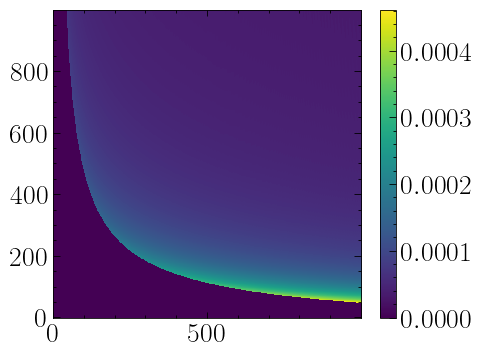

In [16]:
plt.imshow(CLASS_P1, cmap='viridis', interpolation='none',origin='lower')
plt.colorbar()  # Add color bar to show scale
plt.show()


# Plot Figure 3

In [17]:
print(AllSimsCol)

                        label         Lx        Ly         Lz  Ntot   density  \
0    RSEED5.0_ZSCALE1.0_RHO93  156.49532  154.8902  158.07951  1616  0.002614   
1    RSEED5.0_ZSCALE1.0_RHO95  156.49532  154.8902  158.07951  1198  0.002505   
2    RSEED5.0_ZSCALE1.0_RHO97  156.49532  154.8902  158.07951   805  0.002402   
3    RSEED5.0_ZSCALE1.2_RHO97  156.49532  154.8902  189.69541   805  0.002002   
4   RSEED6.0_ZSCALE0.65_RHO91  156.49532  154.8902  102.75168  1040  0.003790   
5   RSEED6.0_ZSCALE0.65_RHO92  156.49532  154.8902  102.75168   961  0.003758   
6   RSEED6.0_ZSCALE0.72_RHO91  156.49532  154.8902  113.81725  1040  0.003422   
7   RSEED6.0_ZSCALE0.72_RHO92  156.49532  154.8902  113.81725   961  0.003393   
8   RSEED6.0_ZSCALE0.75_RHO91  156.49532  154.8902  118.55963  1040  0.003285   
9   RSEED6.0_ZSCALE0.75_RHO92  156.49532  154.8902  118.55963   961  0.003257   
10  RSEED6.0_ZSCALE0.78_RHO92  156.49532  154.8902  123.30202  1355  0.003264   
11  RSEED6.0_ZSCALE0.78_RHO9

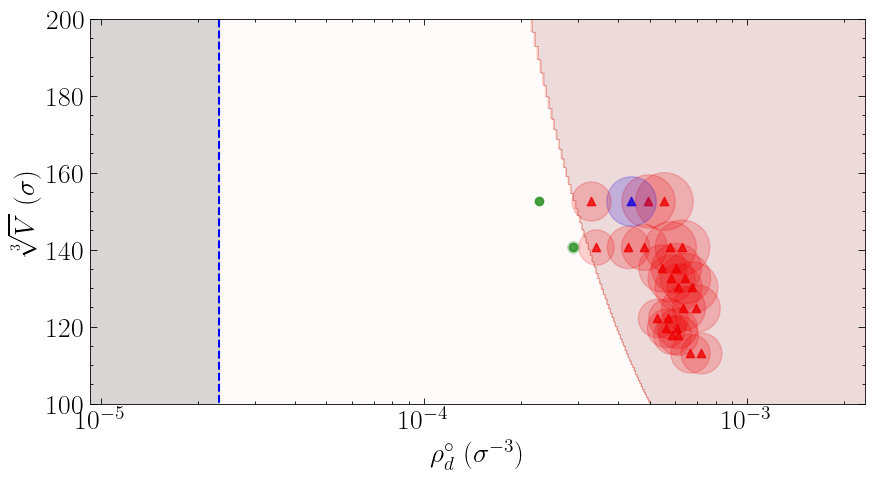

In [18]:
#Map figure
fig = plt.figure(figsize=(10,5)) 
subCol = fig.add_subplot()

#Load data for Col
VColAll=AllSimsCol.Lx*AllSimsCol.Ly*AllSimsCol.Lz - SurfVol
p0ColAll=kT*(AllSimsCol.Ntot)/VColAll

#Plot Map 
for i in range(len(AllSimsCol.Ntot)):
    subCol.scatter(p0ColAll[i]/kT,np.power(VColAll[i],1/3),color=AllSimsCol.c[i],marker=AllSimsCol.m[i],alpha=0.8)
    subCol.scatter(p0ColAll[i]/kT,np.power(VColAll[i],1/3),color=AllSimsCol.c[i],s=AllSimsCol.Nss[i],alpha=0.2)

subCol.contourf(PP0/kT,np.power(VVtot,1/3),CLASS_Col,cmap='Reds',alpha=0.15)
subCol.contour(PP0/kT,np.power(VVtot,1/3),CLASS_Col,[1],colors=['r'])
subCol.plot([LD_Col_estimate, LD_Col_estimate],[np.min(np.power(Vtot,1/3)), np.max(np.power(Vtot,1/3))],'--',color='blue',lw=1.5)
subCol.add_patch(Rectangle((0,0),LD_Col_estimate,400,color='black',alpha=0.15))
#subCol.plot([VD_Col_estimate, VD_Col_estimate],[np.min(np.power(Vtot,1/3)), np.max(np.power(Vtot,1/3))],'--',color='blue',lw=1.5)
#subCol.add_patch(Rectangle((0,0),VD_Col_estimate,400,color='black',alpha=0.15))
subCol.set_xlabel('$\\rho_d^\circ~(\sigma^{-3})$')
subCol.set_ylabel('$\sqrt[3]{V}~(\sigma)$')
subCol.set_xscale('log')
#subCol.set_xlim(0.4*peq_Col_estimate,peq_Col_estimate*200)
subCol.set_xlim(0.4*pequil_Col_estimate,pequil_Col_estimate*100)
subCol.set_ylim(100,200)



plt.savefig('PD.png', dpi=600, bbox_inches='tight');

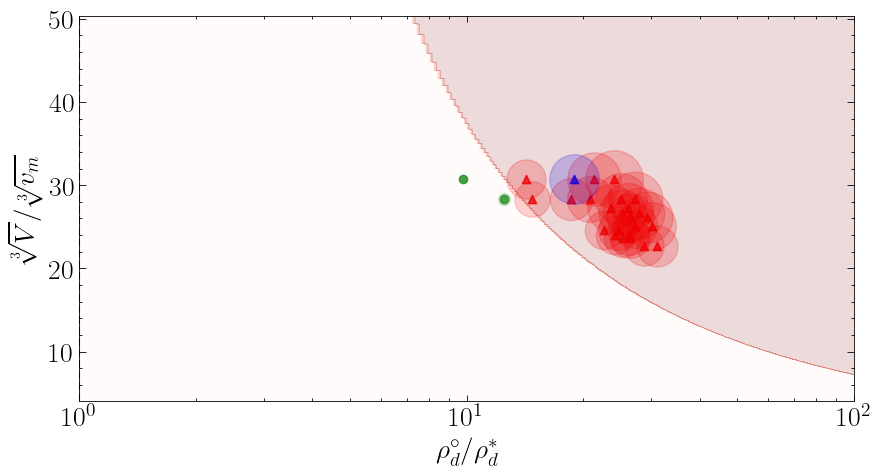

In [19]:
#Map figure
fig = plt.figure(figsize=(10,5)) 
subCol = fig.add_subplot()

#Plot Map 
for i in range(len(AllSimsCol.Ntot)):
    subCol.scatter(p0ColAll[i]/kT/LD_Col_estimate,np.power(VColAll[i],1/3)/np.power(vlCol,1/3),color=AllSimsCol.c[i],marker=AllSimsCol.m[i],alpha=0.8)
    #subCol.scatter(p0ColAll[i]*weightCol/kT,np.power(VColAll[i],1/3),color='r',marker=m[i],alpha=0.8)
    subCol.scatter(p0ColAll[i]/kT/LD_Col_estimate,np.power(VColAll[i],1/3)/np.power(vlCol,1/3),color=AllSimsCol.c[i],s=AllSimsCol.Nss[i],alpha=0.2)

subCol.contourf(PP0/kT/LD_Col_estimate,np.power(VVtot,1/3)/np.power(vlCol,1/3),CLASS_Col,cmap='Reds',alpha=0.15)
subCol.contour(PP0/kT/LD_Col_estimate,np.power(VVtot,1/3)/np.power(vlCol,1/3),CLASS_Col,[1],colors=['r'])
subCol.plot([1, 1],[np.min(np.power(Vtot,1/3)/np.power(vlCol,1/3)), np.max(np.power(Vtot,1/3)/np.power(vlCol,1/3))],'--',color='blue',lw=1.5)
#subCol.scatter(p0Col/kT/LD_Col_estimate,np.power(VCol,1/3)/np.power(vlCol,1/3),color='red',s=1.5*dataCol.Nss,alpha=0.2)
subCol.set_xlabel('$\\rho_d^\circ/\\rho_d^*$')
subCol.set_ylabel('$\sqrt[3]{V}/\sqrt[3]{v_m}$')
subCol.set_xscale('log')
subCol.set_xlim(1,100)
subCol.set_ylim(np.min(np.power(Vtot,1/3)/np.power(vlCol,1/3)),np.max(np.power(Vtot,1/3)/np.power(vlCol,1/3)))


plt.savefig('PD-Sv.png', dpi=600, bbox_inches='tight');